This notebook is intended to aid the construction of a first pointing model with the Auxiliary Telescope. 

At this early stages, and given the small field-of-view of the telescope, it is really hard to get a start on the field. To help on the process, this notebook implements a Gridding routine. The routine will scan around the current position of the telescope and waits for the user to specify if is should continue, go to the next or previous pointing or stop. 



In [1]:
import logging
import yaml

import numpy as np
from matplotlib import pyplot as plt
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5
import asyncio

# import palpy

from lsst.ts import salobj

from lsst.ts.standardscripts.auxtel.attcs import ATTCS

from lsst.ts.idl.enums import ATPtg

%matplotlib inline

## Disable auto download of iers data. 

The main reason for disabling this is that the containers on the control network do not have access to the internet. Trying to download data when there is no outside access means a long time before the connection times out. 

In [ ]:
from astropy.utils import iers
iers.conf.auto_download = False

## Check value of the `LSST_DDS_DOMAIN` variable.

For the AT early work at the summit, the expected value for `LSST_DDS_DOMAIN=lsatmcs`

In [ ]:
import os
print(os.environ["LSST_DDS_DOMAIN"])

## Create a domain and remotes

The ATTCS class uses the following remotes:

  - atmcs 
  - atptg
  - ataos
  - atpneumatics 
  - athexapod
  - atdome
  - atdometrajectory


In [2]:
d = salobj.Domain()

In case, you need to build the idl files, copy the following command to a cell and run it. 

```
%%script bash 
make_idl_files.py ATMCS ATPtg ATAOS ATPneumatics ATHexapod ATDome ATDomeTrajectory
```

In [3]:
atmcs = salobj.Remote(d, "ATMCS")
atptg = salobj.Remote(d, "ATPtg")

In [4]:
await asyncio.gather(atmcs.start_task, 
                     atptg.start_task)

[None, None]

In [ ]:
attcs = ATTCS(atmcs=atmcs, 
              atptg=atptg, 
              ataos=ataos, 
              atpneumatics=atpne, 
              athexapod=athex, 
              atdome=atdome, 
              atdometrajectory=atdomtraj, 
              check={"atpneumatics": False, "athexapod": False, "atdome": True, "atdometrajectory": True})

# Slew and Track an Alt/Az position

While the pointing component does not support the slew and track of an alt/az position, the following cells will provide a quick and easy way to perform this task. The user specified a position in Alt/Az and it will use astropy coordinate library to convert it to RA/Dec. 

For that we will need the location of the observatory and the time. Location is defined as an astropy `EarthLocation` and time is taken from the pointing component and then creating an astropy `Time` object.

Obervatory location (lon, lat and height extracted from: https://github.com/lsst/sims_utils)

In [26]:
location = EarthLocation.from_geodetic(lon=-70.747698*u.deg,
                                       lat=-30.244728*u.deg,
                                       height=2663.0*u.m)

In [ ]:
alt = 70. * u.deg
az = 0. * u.deg

The next cell will convert the specified Alt/Az into RA/Dec coordinates in ICRS. This coordinate will be used to slew and track. 

In [ ]:
time_data = await atptg.tel_timeAndDate.next(flush=True, timeout=2)
curr_time_atptg = Time(time_data.tai, format="mjd", scale="tai")
time_err = curr_time_atptg - Time.now()
print(f"Time error={time_err.sec:0.2f} sec")

# Compute RA/Dec for commanded az/el
cmd_elaz = AltAz(alt=alt, az=az, 
                 obstime=curr_time_atptg.tai, 
                 location=location)
cmd_radec = cmd_elaz.transform_to(ICRS)

await attcs.slew(ra=cmd_radec.ra.hour, 
                 dec=cmd_radec.dec.deg, 
                 rotPA=180.-cmd_elaz.alt.deg,
                 rot_frame=ATPtg.RotFrame.FIXED,
                 rot_mode=ATPtg.RotMode.FIELD)

print(f"raDecTarget ra={cmd_radec.ra!r} hour; "
      f"declination={cmd_radec.dec!r} deg")
# script.ataos.cmd_enableCorrection.set(hexapod=True)
# await script.ataos.cmd_enableCorrection.start(timeout=10)



# Slew and track a RA/Dec target

The next cell shows an example of how to slew and track an RA/Dec target. 

The one caveat with slewing to RA/Dec is getting a proper value for rotPA. We currently want to keep the rotator around zero degrees. We need to improve the handling of this rotation angle on the slew method but right now we compute the angle on the cell. 

In [ ]:
ra = Angle('19:05:24', unit=u.hour)
dec = Angle('+13:51:47', unit=u.deg)
target_name="HR 7235"

radec = ICRS(ra, dec)

# Figure out what is the rotPA that sets nasmith rotator close to zero.
time_data = await atptg.tel_timeAndDate.next(flush=True, timeout=2)
curr_time_atptg = Time(time_data.tai, format="mjd", scale="tai")
coord_frame_altaz = AltAz(location=location, obstime=curr_time_atptg)
alt_az = radec.transform_to(coord_frame_altaz)

await attcs.slew(ra=ra, 
                 dec=dec,
                 rotPA=180.-alt_az.alt.deg,
                 rot_frame=ATPtg.RotFrame.FIXED,
                 rot_mode=ATPtg.RotMode.FIELD)

# Slew and track the MOON (and other solar system body)

In [ ]:
await attcs.slew_to_planet(planet=ATPtg.Planets.MOON)

# GRID in RA/Dec

In [ ]:
dra_grid = np.arange(-1., 1.1,0.1)*24./360.
ddec_grid = np.arange(-1., 1.1,0.1)

In [ ]:
grid_ra = np.zeros(len(dra_grid)*len(ddec_grid))
grid_dec = np.zeros(len(dra_grid)*len(ddec_grid))

for i in range(len(ddec_grid)):
    grid_ra[i*len(dra_grid):(i+1)*len(dra_grid)] += dra_grid[::(-1)**i]
    grid_dec[i*len(dra_grid):(i+1)*len(dra_grid)] += ddec_grid[i]

In [ ]:
plt.plot(grid_ra[0], grid_dec[0], 'bo')
plt.plot(grid_ra, grid_dec, ':')
plt.plot(grid_ra[-1], grid_dec[-1], 'go')

In [18]:
async def wait_center():
    while True:
        opt = input("Center telescope and choose action (press ?<enter>, for list of actions): ")
        
        if opt == 'n':
            print("Next point in the grid...")
            return 1
        elif opt == 'p':
            print("Previous point in the grid...")
            return -1
        elif opt == 't':
            print("Stopping test...")
            return 0
        elif opt == '?':
            print("""Options are:
            n - Go to next point in the grid.
            p - Go to previous point in the grid.
            t - Terminate test.
            """)
        else:
            print("Next point in the grid...")
            return 1

In [61]:
ra = Angle("01:37:42.84548", unit=u.hour)
dec = Angle("-57:14:12.3101", unit=u.deg)
target_name="Alpha Eri"

radec = ICRS(ra, dec)

start_from = 0

In [62]:
await atptg.cmd_stopTracking.start()

RemoteEvent(ATMCS, 0, target) falling behind; read 100 messages
RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 100 messages
RemoteEvent(ATPtg, 0, weatherDataApplied) falling behind; read 28 messages


In [63]:
# Figure out what is the rotPA that sets nasmith rotator close to zero.
time_data = await atptg.tel_timeAndDate.next(flush=True, timeout=2)
curr_time_atptg = Time(time_data.tai, format="mjd", scale="tai")
print(curr_time_atptg)
coord_frame_altaz = AltAz(location=location, obstime=curr_time_atptg)
alt_az = radec.transform_to(coord_frame_altaz)

print("slew...")
# await atmcs.cmd_startTracking.start(timeout=10)
await atptg.cmd_raDecTarget.set_start(
    targetName=target_name,
    targetInstance=ATPtg.TargetInstances.CURRENT,
    frame=ATPtg.CoordFrame.ICRS,
    epoch=2000,  # should be ignored: no parallax or proper motion
    equinox=2000,  # should be ignored for ICRS
    ra=radec.ra.hour,
    declination=radec.dec.deg,
    parallax=0,
    pmRA=0,
    pmDec=0,
    rv=0,
    dRA=0,
    dDec=0,
    rotPA=180.-alt_az.alt.deg,
    rotFrame=ATPtg.RotFrame.FIXED,
    rotMode=ATPtg.RotMode.FIELD,
    timeout=10
)

58829.06876392226
slew...


In [ ]:
start_from = 0

In [ ]:
print(f"Grid has {len(grid_ra)} pointings...")
print(f"Starting from {start_from}")

i = start_from
stop_at = 0

# Figure out what is the rotPA that sets nasmith rotator close to zero.
time_data = await atptg.tel_timeAndDate.next(flush=True, timeout=2)
curr_time_atptg = Time(time_data.tai, format="mjd", scale="tai")
coord_frame_altaz = AltAz(location=location, obstime=curr_time_atptg)
alt_az = radec.transform_to(coord_frame_altaz)


while i < len(grid_ra):
    
    print(f"GRID[{i}]: {grid_ra[i]} x {grid_dec[i]}")

    await attcs.slew(ra=ra.hour + grid_ra[i], 
                     dec=dec.deg + grid_dec[i],
                     rotPA=180.-alt_az.alt.deg,
                     target_name=f"{target_name} RA/Dec GRID[{i}]: {grid_ra[i]} x {grid_dec[i]}",
                     rot_frame=ATPtg.RotFrame.FIXED,
                     rot_mode=ATPtg.RotMode.FIELD)
    
    ret_val = await wait_center()
    if ret_val == 0:
        break

    i += ret_val

    if i < 0:
        print(f"Unwrapping index! (i={i})")
        i = 0


# GRID in Alt/Az

In [6]:
dalt_grid = np.arange(-0.5, +0.6, 0.1)
daz_grid = np.arange(-0.5, +0.6, 0.1)

In [7]:
grid_alt = np.zeros(len(dalt_grid)*len(daz_grid))
grid_az = np.zeros(len(dalt_grid)*len(daz_grid))

for i in range(len(daz_grid)):
    grid_alt[i*len(dalt_grid):(i+1)*len(dalt_grid)] += dalt_grid[::(-1)**i]
    grid_az[i*len(dalt_grid):(i+1)*len(dalt_grid)] += daz_grid[i]

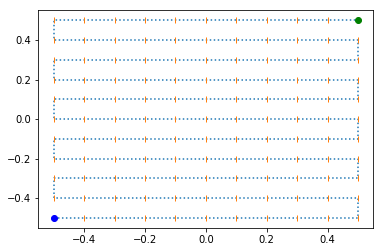

In [8]:
plt.plot(grid_alt, grid_az, ':')
plt.plot(grid_alt, grid_az, '|')
plt.plot(grid_alt[0], grid_az[0], 'bo')
plt.plot(grid_alt[-1], grid_az[-1], 'go')

In [11]:
start_from=0

In [19]:
print(f"Grid has {len(grid_alt)} pointings...")
print(f"Starting from {start_from}")

i = start_from
stop_at = 0

while i < len(grid_alt):
    
    print(f"GRID[{i}]: {grid_alt[i]} x {grid_az[i]}")

    await atptg.cmd_offsetAzEl.set_start(el=grid_alt[i]*60.*60., 
                                         az=grid_az[i]*60*60, 
                                         num=0)
    
    ret_val = await wait_center()

    if ret_val == 0:
        break
        
    i += ret_val
    
    if i < 0:
        print(f"Unwrapping index! (i={i})")
        i = 0

Grid has 121 pointings...
Starting from 0
GRID[0]: -0.5 x -0.5


RemoteTelemetry(ATPtg, 0, skyEnvironment) falling behind; read 15 messages


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[1]: -0.4 x -0.5


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 35 messages
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 35 messages
RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 36 messages


Next point in the grid...
GRID[2]: -0.30000000000000004 x -0.5


RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 36 messages


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATMCS, 0, trajectory) falling behind; read 10 messages
RemoteTelemetry(ATMCS, 0, torqueDemand) falling behind; read 10 messages
RemoteTelemetry(ATMCS, 0, nasymth_m3_mountMotorEncoders) falling behind; read 11 messages


Next point in the grid...
GRID[3]: -0.20000000000000007 x -0.5


RemoteTelemetry(ATMCS, 0, mount_Nasmyth_Encoders) falling behind; read 11 messages
RemoteTelemetry(ATMCS, 0, measuredTorque) falling behind; read 11 messages
RemoteTelemetry(ATMCS, 0, measuredMotorVelocity) falling behind; read 11 messages


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[4]: -0.10000000000000009 x -0.5


RemoteTelemetry(ATMCS, 0, trajectory) falling behind; read 28 messages
RemoteTelemetry(ATMCS, 0, torqueDemand) falling behind; read 28 messages


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 11 messages


Next point in the grid...
GRID[5]: -1.1102230246251565e-16 x -0.5


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 15 messages
RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 16 messages


Next point in the grid...
GRID[6]: 0.09999999999999987 x -0.5


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[7]: 0.19999999999999984 x -0.5


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[8]: 0.2999999999999998 x -0.5


RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 73 messages


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[9]: 0.3999999999999998 x -0.5


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 14 messages


Next point in the grid...
GRID[10]: 0.4999999999999998 x -0.5


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 14 messages


Next point in the grid...
GRID[11]: 0.4999999999999998 x -0.4


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[12]: 0.3999999999999998 x -0.4


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 11 messages
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 12 messages


Next point in the grid...
GRID[13]: 0.2999999999999998 x -0.4


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 13 messages
RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 13 messages


Next point in the grid...
GRID[14]: 0.19999999999999984 x -0.4


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[15]: 0.09999999999999987 x -0.4


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 12 messages


Next point in the grid...
GRID[16]: -1.1102230246251565e-16 x -0.4


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[17]: -0.10000000000000009 x -0.4


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[18]: -0.20000000000000007 x -0.4


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 13 messages


Next point in the grid...
GRID[19]: -0.30000000000000004 x -0.4


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 15 messages
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 14 messages
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 15 messages
RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 15 messages


Next point in the grid...
GRID[20]: -0.4 x -0.4


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[21]: -0.5 x -0.4


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 13 messages


Next point in the grid...
GRID[22]: -0.5 x -0.30000000000000004


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 13 messages


Next point in the grid...
GRID[23]: -0.4 x -0.30000000000000004


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 11 messages


Next point in the grid...
GRID[24]: -0.30000000000000004 x -0.30000000000000004


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteEvent(ATMCS, 0, target) falling behind; read 40 messages
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 10 messages
RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 10 messages
RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 10 messages


Next point in the grid...
GRID[25]: -0.20000000000000007 x -0.30000000000000004


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 12 messages


Next point in the grid...
GRID[26]: -0.10000000000000009 x -0.30000000000000004


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 10 messages


Next point in the grid...
GRID[27]: -1.1102230246251565e-16 x -0.30000000000000004


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 12 messages


Next point in the grid...
GRID[28]: 0.09999999999999987 x -0.30000000000000004


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 11 messages


Next point in the grid...
GRID[29]: 0.19999999999999984 x -0.30000000000000004


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 18 messages


Next point in the grid...
GRID[30]: 0.2999999999999998 x -0.30000000000000004


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 28 messages
RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 28 messages
RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 29 messages


Next point in the grid...
GRID[31]: 0.3999999999999998 x -0.30000000000000004


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 11 messages


Next point in the grid...
GRID[32]: 0.4999999999999998 x -0.30000000000000004


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 12 messages
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 13 messages
RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 13 messages
RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 13 messages


Next point in the grid...
GRID[33]: 0.4999999999999998 x -0.20000000000000007


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 16 messages


Next point in the grid...
GRID[34]: 0.3999999999999998 x -0.20000000000000007


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 14 messages


Next point in the grid...
GRID[35]: 0.2999999999999998 x -0.20000000000000007


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 12 messages


Next point in the grid...
GRID[36]: 0.19999999999999984 x -0.20000000000000007


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[37]: 0.09999999999999987 x -0.20000000000000007


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[38]: -1.1102230246251565e-16 x -0.20000000000000007


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 13 messages


Next point in the grid...
GRID[39]: -0.10000000000000009 x -0.20000000000000007


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 100 messages


Next point in the grid...
GRID[40]: -0.20000000000000007 x -0.20000000000000007


RemoteTelemetry(ATPtg, 0, skyEnvironment) falling behind; read 31 messages
RemoteTelemetry(ATPtg, 0, currentTimesToLimits) falling behind; read 31 messages
RemoteEvent(ATPtg, 0, weatherDataApplied) falling behind; read 15 messages


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[41]: -0.30000000000000004 x -0.20000000000000007


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 11 messages


Next point in the grid...
GRID[42]: -0.4 x -0.20000000000000007


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[43]: -0.5 x -0.20000000000000007


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[44]: -0.5 x -0.10000000000000009


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[45]: -0.4 x -0.10000000000000009


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[46]: -0.30000000000000004 x -0.10000000000000009


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 10 messages
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 10 messages


Next point in the grid...
GRID[47]: -0.20000000000000007 x -0.10000000000000009


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[48]: -0.10000000000000009 x -0.10000000000000009


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[49]: -1.1102230246251565e-16 x -0.10000000000000009


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 14 messages


Next point in the grid...
GRID[50]: 0.09999999999999987 x -0.10000000000000009


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 16 messages
RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 16 messages


Next point in the grid...
GRID[51]: 0.19999999999999984 x -0.10000000000000009


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 12 messages


Next point in the grid...
GRID[52]: 0.2999999999999998 x -0.10000000000000009


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 10 messages


Next point in the grid...
GRID[53]: 0.3999999999999998 x -0.10000000000000009


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[54]: 0.4999999999999998 x -0.10000000000000009


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 14 messages


Next point in the grid...
GRID[55]: 0.4999999999999998 x -1.1102230246251565e-16


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[56]: 0.3999999999999998 x -1.1102230246251565e-16


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 18 messages
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 18 messages


Next point in the grid...
GRID[57]: 0.2999999999999998 x -1.1102230246251565e-16


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 11 messages


Next point in the grid...
GRID[58]: 0.19999999999999984 x -1.1102230246251565e-16


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[59]: 0.09999999999999987 x -1.1102230246251565e-16


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[60]: -1.1102230246251565e-16 x -1.1102230246251565e-16


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[61]: -0.10000000000000009 x -1.1102230246251565e-16


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 11 messages


Next point in the grid...
GRID[62]: -0.20000000000000007 x -1.1102230246251565e-16


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[63]: -0.30000000000000004 x -1.1102230246251565e-16


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[64]: -0.4 x -1.1102230246251565e-16


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[65]: -0.5 x -1.1102230246251565e-16


RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 13 messages


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 16 messages
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 16 messages


Next point in the grid...
GRID[66]: -0.5 x 0.09999999999999987


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 12 messages


Next point in the grid...
GRID[67]: -0.4 x 0.09999999999999987


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 12 messages


Next point in the grid...
GRID[68]: -0.30000000000000004 x 0.09999999999999987


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 10 messages


Next point in the grid...
GRID[69]: -0.20000000000000007 x 0.09999999999999987


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 12 messages
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 12 messages
RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 13 messages


Next point in the grid...
GRID[70]: -0.10000000000000009 x 0.09999999999999987


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 13 messages
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 13 messages
RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 14 messages


Next point in the grid...
GRID[71]: -1.1102230246251565e-16 x 0.09999999999999987


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[72]: 0.09999999999999987 x 0.09999999999999987


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[73]: 0.19999999999999984 x 0.09999999999999987


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 13 messages
RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 13 messages


Next point in the grid...
GRID[74]: 0.2999999999999998 x 0.09999999999999987


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[75]: 0.3999999999999998 x 0.09999999999999987


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 11 messages


Next point in the grid...
GRID[76]: 0.4999999999999998 x 0.09999999999999987


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[77]: 0.4999999999999998 x 0.19999999999999984


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[78]: 0.3999999999999998 x 0.19999999999999984


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[79]: 0.2999999999999998 x 0.19999999999999984


RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 70 messages
RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 70 messages
RemoteEvent(ATMCS, 0, heartbeat) falling behind; read 15 messages


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[80]: 0.19999999999999984 x 0.19999999999999984


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[81]: 0.09999999999999987 x 0.19999999999999984


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 13 messages
RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 13 messages


Next point in the grid...
GRID[82]: -1.1102230246251565e-16 x 0.19999999999999984


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[83]: -0.10000000000000009 x 0.19999999999999984


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 14 messages


Next point in the grid...
GRID[84]: -0.20000000000000007 x 0.19999999999999984


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 14 messages


Next point in the grid...
GRID[85]: -0.30000000000000004 x 0.19999999999999984


Center telescope and choose action (press ?<enter>, for list of actions):  


RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 10 messages


Next point in the grid...
GRID[86]: -0.4 x 0.19999999999999984


Center telescope and choose action (press ?<enter>, for list of actions):  


Next point in the grid...
GRID[87]: -0.5 x 0.19999999999999984


RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 86 messages
RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 86 messages


Center telescope and choose action (press ?<enter>, for list of actions):  p


Previous point in the grid...
GRID[86]: -0.4 x 0.19999999999999984


Center telescope and choose action (press ?<enter>, for list of actions):  t


Stopping test...


In [66]:
await atptg.cmd_offsetAzEl.set_start(el=-0.39*60.*60., 
                                     az=0.25*60.*60., 
                                     num=0)


RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 28 messages


In [65]:
await atptg.cmd_offsetAzEl.set_start(el=-0.380*60.*60., 
                                     az=0.251*60.*60., 
                                     num=0)

In [55]:
await atptg.cmd_pointNewFile.start()
await asyncio.sleep(1.)
await atptg.cmd_pointAddData.start()
await asyncio.sleep(1.)
await atptg.cmd_pointCloseFile.start()

RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 39 messages
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 39 messages
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 39 messages


In [56]:
time_data = await atptg.tel_timeAndDate.next(flush=True, timeout=2)

RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 100 messages
RemoteEvent(ATMCS, 0, target) falling behind; read 100 messages
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 100 messages
RemoteTelemetry(ATMCS, 0, trajectory) falling behind; read 57 messages
RemoteTelemetry(ATPtg, 0, skyEnvironment) falling behind; read 11 messages
RemoteTelemetry(ATMCS, 0, torqueDemand) falling behind; read 57 messages
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 100 messages
RemoteTelemetry(ATMCS, 0, nasymth_m3_mountMotorEncoders) falling behind; read 57 messages
RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 100 messages
RemoteTelemetry(ATMCS, 0, mount_Nasmyth_Encoders) falling behind; read 57 messages


In [57]:
time_data.lst

'1:54:29.4'

In [67]:
atdome = salobj.Remote(d, "ATDome")

In [68]:
await atdome.start_task

RemoteEvent(ATMCS, 0, azimuthInPosition) falling behind; read 32 messages
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 100 messages
RemoteTelemetry(ATPtg, 0, skyEnvironment) falling behind; read 100 messages
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 100 messages
RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 100 messages
RemoteTelemetry(ATPtg, 0, currentTimesToLimits) falling behind; read 100 messages


In [72]:
await atdome.cmd_moveAzimuth.set_start(azimuth=65)

RemoteTelemetry(ATDome, 0, position) falling behind; read 100 messages
RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 100 messages
